<a href="https://colab.research.google.com/github/rolitta/Deeplearning_classification/blob/main/model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U segmentation-models
!pip install tensorflow
!pip install gradio

In [ ]:
from tensorflow import keras
import os
import cv2
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import random

In [ ]:
from keras.models import Model
import gradio as gr

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [ ]:
from keras import backend as K
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
from matplotlib.colors import ListedColormap
# Define the colors for each class
colors = [
    (0, 0, 1),       # blue for water
    (0.6, 0.3, 0),   # brown for land
    (0.5, 0.5, 0.5), # grey for road
    (1, 0.5, 0),       # red for building
    (0, 1, 0),       # green for vegetation
    (0, 0, 0)        # black for unlabeled
]

# Create a colormap
cmap = ListedColormap(colors)

In [ ]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value

In [ ]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]
dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

In [ ]:
satellite_model = load_model('/content/satellite-imagery1.h5',
                         custom_objects=({'dice_loss_plus_1focal_loss': total_loss,
                                          'jaccard_coef': jaccard_coef}))

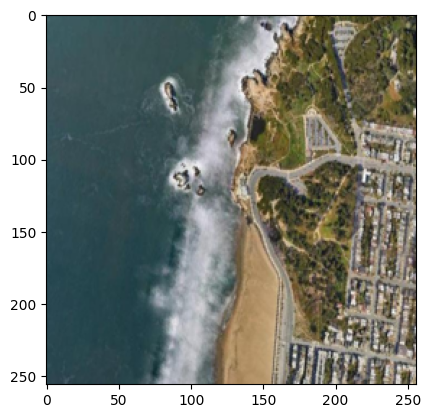

In [ ]:
minmaxscaler = MinMaxScaler()
image = Image.open('/content/image.jpg')
image = image.resize((256,256))
plt.imshow(image)
image = np.array(image)
image = np.expand_dims(image, 0)
image = minmaxscaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)

In [ ]:

prediction = satellite_model.predict(image)

1/1 [==============================] - 2s 2s/step


In [ ]:

predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]


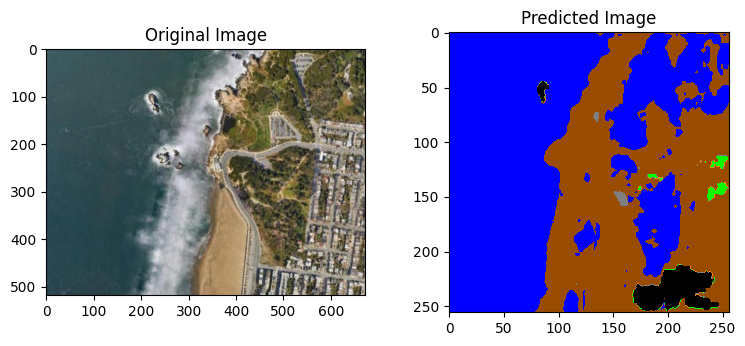

In [ ]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(Image.open('/content/image.jpg'))
plt.subplot(232)
plt.title("Predicted Image")
plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=5)

In [26]:
def process_input_image(image_source):
    # Resize the image to (256, 256)
    image = Image.fromarray(image_source).resize((256, 256))
    image = np.expand_dims(image, 0)  # Expand dimensions to (1, 256, 256, 3)

    image = image / 255.0

    prediction = satellite_model.predict(image)
    predicted_image = np.argmax(prediction, axis=3)

    predicted_image = predicted_image[0, :, :]
    predicted_image = predicted_image * 50
    return 'Predicted Masked Image', predicted_image

with gr.Blocks() as my_app:
    gr.Markdown("Satellite Image Segmentation Application UI with Gradio")
    with gr.Tabs():
        with gr.TabItem("Select your image"):
            with gr.Row():
                with gr.Column():
                    img_source = gr.Image(label="Please select source Image")
                    source_image_loader = gr.Button("Load above Image")
                with gr.Column():
                    output_label = gr.Label(label="Image Info")
                    img_output = gr.Image(label="Image Output")
    source_image_loader.click(
        process_input_image,
        [img_source],
        [output_label, img_output]
    )

my_app.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://5ec6a85dbf943594a0.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [22]:
my_app.close()

Closing server running on port: 7861
